In [ ]:
#default_exp medical.imaging

# Medical Imaging

> Helpers for working with DICOM files

In [ ]:
#export 
from local.torch_basics import *
from local.test import *
from local.core import *
from local.layers import *
from local.data.all import *
from local.optimizer import *
from local.learner import *
from local.metrics import *
from local.vision import models

import pydicom
from pydicom.dataset import Dataset as DcmDataset
from pydicom.tag import BaseTag as DcmTag
from pydicom.multival import MultiValue as DcmMultiValue

from scipy import ndimage
import skimage

In [ ]:
from local.notebook.showdoc import *

In [ ]:
#export
_all_ = ['DcmDataset', 'DcmTag', 'DcmMultiValue']

In [ ]:
#export
@patch
def dcmread(self:Path): return pydicom.dcmread(str(self))

In [ ]:
TEST_DCM = Path('images/sample.dcm')
dcm = TEST_DCM.dcmread()

In [ ]:
#export
@patch_property
def pixels(self:DcmDataset):
    "`pixel_array` as a tensor"
    return tensor(self.pixel_array.astype(np.float32))

In [ ]:
#export
@patch_property
def scaled_px(self:DcmDataset):
    "`pixels` scaled by `RescaleSlope` and `RescaleIntercept"
    img = self.pixels
    return img*self.RescaleSlope + self.RescaleIntercept

In [ ]:
#export
def array_freqhist_bins(self, n_bins=100):
    imsd = np.sort(self.flatten())
    t = np.array([0.001])
    t = np.append(t, np.arange(n_bins)/n_bins+(1/2/n_bins))
    t = np.append(t, 0.999)
    t = (len(imsd)*t+0.5).astype(np.int)
    return np.unique(imsd[t])

In [ ]:
#export
@patch
def freqhist_bins(self:Tensor, n_bins=100):
    imsd = self.view(-1).sort()[0]
    t = torch.cat([tensor([0.001]),
                   torch.arange(n_bins).float()/n_bins+(1/2/n_bins),
                   tensor([0.999])])
    t = (len(imsd)*t).long()
    return imsd[t].unique()

In [ ]:
#export
@patch
def hist_scaled(self:Tensor, brks=None):
    if brks is None: brks = self.freqhist_bins()
    ys = torch.arange(len(brks), dtype=torch.float) / brks[-1]
    return self.flatten().interp_1d(brks, ys).reshape(self.shape)

In [ ]:
#export
@patch
def hist_scaled_px(self:DcmDataset, brks=None):
    return self.pixels.hist_scaled()

In [ ]:
#export
@patch
def windowed(self:DcmDataset, w, l):
    px = self.scaled_px.float()
    px_min = l - w//2
    px_max = l + w//2
    px[px<px_min] = px_min
    px[px>px_max] = px_max
    return (px-px_min) / (px_max-px_min)

In [ ]:
#export
# From https://radiopaedia.org/articles/windowing-ct
dicom_windows = types.SimpleNamespace(
    brain=(80,40),
    subdural=(200,80),
    stroke=(8,32),
    brain_bone=(2800,600),
    brain_soft=(375,40),
    lungs=(1500,-600),
    mediastinum=(350,50),
    abdomen_soft=(400,50),
    liver=(150,30),
    spine_soft=(250,50),
    spine_bone=(1800,400)
)

In [ ]:
#export
@patch
@delegates(show_image)
def show(self:DcmDataset, scale=True, cmap=plt.cm.bone, **kwargs):
    px = (self.windowed(*scale) if isinstance(scale,tuple)
          else dcm.hist_scaled_px() if scale
          else self.scaled_px)
    show_image(px, cmap=cmap, **kwargs)

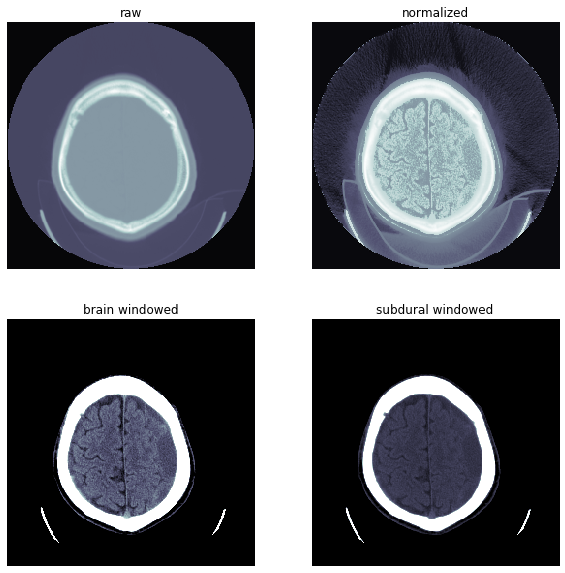

In [ ]:
scales = False, True, dicom_windows.brain, dicom_windows.subdural
titles = 'raw','normalized','brain windowed','subdural windowed'
for s,a,t in zip(scales, subplots(2,2,imsize=5)[1].flat, titles):
    dcm.show(scale=s, ax=a, title=t)

In [ ]:
#export
@patch
def zoom(self:DcmDataset, ratio):
    data_d = ndimage.zoom(self.pixel_array, ratio)
    self.PixelData = data_d.tobytes()
    self.Rows,self.Columns = data_d.shape

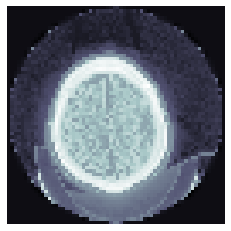

In [ ]:
dcm.zoom(0.25)
dcm.show()

In [ ]:
#export
def _cast_dicom_special(x):
    cls = type(x)
    if not cls.__module__.startswith('pydicom'): return x
    return cls.__base__(x)

def _split_elem(res,k,v):
    if not isinstance(v,DcmMultiValue): return
    res[f'Multi{k}'] = 1
    for i,o in enumerate(v): res[f'{k}{"" if i==0 else i}']=o

In [ ]:
#export
@patch
def as_dict(self:DcmDataset, px_summ=True):
    pxdata = (0x7fe0,0x0010)
    vals = [self[o] for o in self.keys() if o != pxdata]
    its = [(v.keyword,v.value) for v in vals]
    res = dict(its)
    res['fname'] = self.filename
    for k,v in its: _split_elem(res,k,v)
    if not px_summ: return res
    stats = 'min','max','mean','std'
    try:
        pxs = self.pixel_array
        for f in stats: res['img_'+f] = getattr(pxs,f)()
    except Exception as e:
        for f in stats: res['img_'+f] = 0
        print(res,e)
    for k in res: res[k] = _cast_dicom_special(res[k])
    return res

In [ ]:
#export
def _dcm2dict(px_summ, fn): return fn.dcmread().as_dict(px_summ)

In [ ]:
#export
@delegates(parallel)
def _from_dicoms(cls, fns, px_summ=True, **kwargs): return pd.DataFrame(parallel(partial(_dcm2dict,px_summ), fns, **kwargs))
pd.DataFrame.from_dicoms = classmethod(_from_dicoms)

## Export -

In [ ]:
#hide
from local.notebook.export import notebook2script
notebook2script(all_fs=True)

Converted 00_test.ipynb.
Converted 01_core.ipynb.
Converted 01a_utils.ipynb.
Converted 01b_dispatch.ipynb.
Converted 01c_torch_core.ipynb.
Converted 02_script.ipynb.
Converted 03_dataloader.ipynb.
Converted 04_transform.ipynb.
Converted 05_data_core.ipynb.
Converted 06_data_transforms.ipynb.
Converted 07_vision_core.ipynb.
Converted 08_pets_tutorial.ipynb.
Converted 09_vision_augment.ipynb.
Converted 10_data_block.ipynb.
Converted 11_layers.ipynb.
Converted 11a_vision_models_xresnet.ipynb.
Converted 12_optimizer.ipynb.
Converted 13_learner.ipynb.
Converted 14_callback_schedule.ipynb.
Converted 14a_callback_data.ipynb.
Converted 15_callback_hook.ipynb.
Converted 15a_vision_models_unet.ipynb.
Converted 16_callback_progress.ipynb.
Converted 17_callback_tracker.ipynb.
Converted 18_callback_fp16.ipynb.
Converted 19_callback_mixup.ipynb.
Converted 20_metrics.ipynb.
Converted 21_vision_learner.ipynb.
Converted 22_tutorial_imagenette.ipynb.
Converted 23_tutorial_transfer_learning.ipynb.
Conver